<h2 style='color:blue' align='center'> Magic Lens Image Organizer<h2>

In [2]:
#importing of all the necessary librairies needed for the project
import numpy as np
import cv2
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

<h3 style='color:purple'>Step 1 of Preprocessing: Detecting person face and eyes in the image</h3>

In this step when we consider an image of person we use the face of that particular person for the identification of the person. There are various of scenarios in identififying of the person in the image will be difficult.
Such as:- 
        1) Various people faces in the image.
        2) The face of the particular person we focusing can be blockup, shaken , blured.
The intial step in the system pipeline of preprocessing resemble the step such as:
        1) It is to identify the faces from an image.
        2) After the detection of the faces, detecting the eyes of the each faces.
        3) If the two eyes of a faces is observed save the image in a separate folder.
        4) If the two eyes of a face is not obsereved it is considered reduntat or not useful image it will be            better to discard that image to save memory and to provide the clean image data for the modeling.

In [3]:
#reading of the images
img = cv2.imread('./test_images/janakan2.jpg')
img.shape

(3024, 4032, 3)

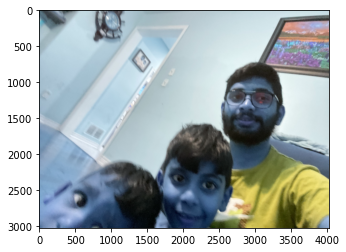

In [4]:
#displaying the image readed
plt.imshow(img)

In [5]:
# creating an array which hold the value of the image in each pixel and converting the 
#RGB value to the gray value and storing it as numpy array
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
gray.shape

(3024, 4032)

In [6]:
#displaying the arrray 
gray

array([[112, 112, 113, ..., 215, 215, 215],
       [116, 116, 115, ..., 215, 215, 215],
       [117, 116, 115, ..., 215, 215, 215],
       ...,
       [110, 119, 116, ..., 174, 175, 175],
       [118, 117, 110, ..., 171, 172, 173],
       [127, 117, 106, ..., 171, 172, 173]], dtype=uint8)

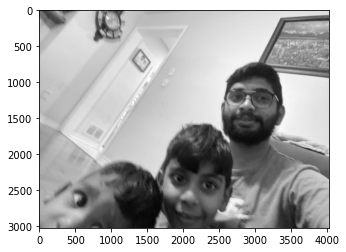

In [7]:
#using pyplot from the matplotlib rereating the gray image using the gray array
plt.imshow(gray, cmap='gray')

<h3 style='color:purple'>Cascading</h3> 
It is particular case of technique which uses the ensemble learning which is based on the combination of various classifiers. It is also can be considered as pipeline process in which passess all the information collected from the output the intial classifier will be passed to the next classifier, this process will flow upto the final classifier. The final classifier output the particular component from the image.
These classifier produces various components to identify from the image. 
In this project team will be using the Cascade classifier of the face and eye.

In [8]:
#using the face and eye cascade classifier
face_cascade = cv2.CascadeClassifier('./opencv/haarcascades/haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier('./opencv/haarcascades/haarcascade_eye.xml')

#finding the particular region of the face in the provided image
faces = face_cascade.detectMultiScale(gray, 1.3, 5)
faces

array([[2492,  879,  836,  836]], dtype=int32)

In [9]:
#location of the face in the image
(x,y,w,h) = faces[0]
x,y,w,h

(2492, 879, 836, 836)

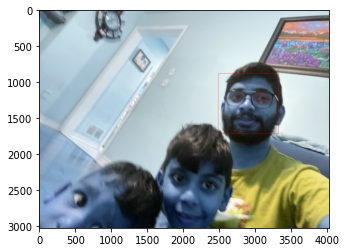

In [10]:
#diplay in red rectangle box in the image
face_img = cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
plt.imshow(face_img)

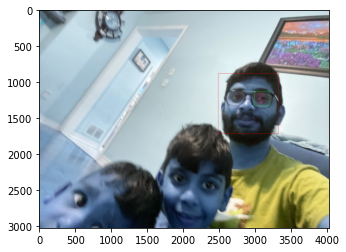

In [11]:
#function used to close all the window opened previously by the script which is image windows
cv2.destroyAllWindows()
# In the identified face of the identifying the both eye of the face region in the image displaying it with the 
# green rectangle
for (x,y,w,h) in faces:
    face_img = cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    roi_gray = gray[y:y+h, x:x+w]
    roi_color = face_img[y:y+h, x:x+w]
    eyes = eye_cascade.detectMultiScale(roi_gray)
    for (ex,ey,ew,eh) in eyes:
        cv2.rectangle(roi_color,(ex,ey),(ex+ew,ey+eh),(0,255,0),2)
        

plt.figure()
plt.imshow(face_img, cmap='gray')
plt.show()

<h3 style='color:purple'>Step two of  Preprocessing: Creating a crop image of the facial region of the image</h3>

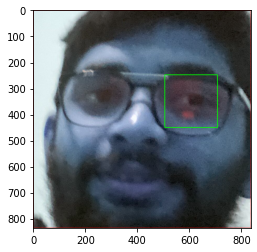

In [12]:
#displaying the cropped image of the identified face in the image
%matplotlib inline
plt.imshow(roi_color, cmap='gray')

In [13]:
cropped_img = np.array(roi_color)
cropped_img.shape

(836, 836, 3)

<h3 style='color:purple'>(3) Preprocessing: Use wavelet transform as a feature for traning our model</h3>

#### In wavelet transformed image, you can see edges clearly and that can give us clues on various facial features such as eyes, nose, lips etc

### Wavelet transform

In [14]:
import numpy as np
import pywt
import cv2    

def w2d(img, mode='haar', level=1):
    imArray = img
    #Datatype conversions
    #convert to grayscale
    imArray = cv2.cvtColor( imArray,cv2.COLOR_RGB2GRAY )
    #convert to float
    imArray =  np.float32(imArray)   
    imArray /= 255;
    # compute coefficients 
    coeffs=pywt.wavedec2(imArray, mode, level=level)

    #Process Coefficients
    coeffs_H=list(coeffs)  
    coeffs_H[0] *= 0;  

    # reconstruction
    imArray_H=pywt.waverec2(coeffs_H, mode);
    imArray_H *= 255;
    imArray_H =  np.uint8(imArray_H)

    return imArray_H

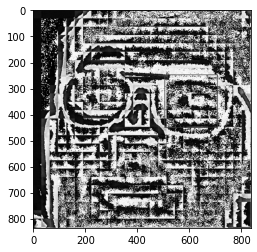

In [15]:
im_har = w2d(cropped_img,'db1',5)
plt.imshow(im_har, cmap='gray')

#### You can see above a wavelet transformed image that gives clues on facial features such as eyes, nose, lips etc. This along with raw pixel image can be used as an input for our classifier

<h3 style='color:purple'>(3) Preprocessing: Load image, detect face. If eyes >=2, then save and crop the face region</h3>

####  Lets write a python function that can take input image and returns cropped image (if face and eyes >=2 are detected)

In [16]:
def get_cropped_image_if_2_eyes(image_path):
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)
    for (x,y,w,h) in faces:
        roi_gray = gray[y:y+h, x:x+w]
        roi_color = img[y:y+h, x:x+w]
        eyes = eye_cascade.detectMultiScale(roi_gray)
        if len(eyes) >= 2:
            return roi_color

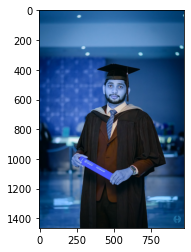

In [17]:
original_image = cv2.imread('./test_images/janakan.jpg')
plt.imshow(original_image)

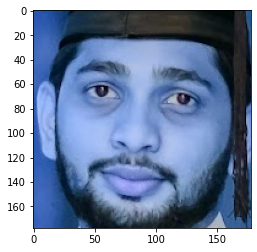

In [18]:
cropped_image = get_cropped_image_if_2_eyes('./test_images/janakan.jpg')
plt.imshow(cropped_image)

**In below image face is not very clear and it doesn't have two eyes clearly visible**

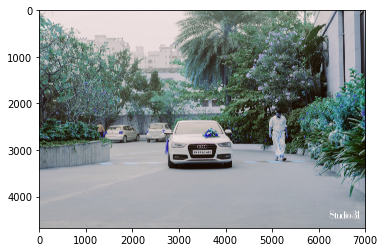

In [19]:
org_image_obstructed = cv2.imread('./test_images/janakan1.jpg')
plt.imshow(org_image_obstructed)

In [20]:
cropped_image_no_2_eyes = get_cropped_image_if_2_eyes('./test_images/janakan1.jpg')
cropped_image_no_2_eyes

**Above cropped_image_no_2_eyes is None which means we should ignore this image and we will not use such image for model training**

In [21]:
path_to_data = "./dataset/"
path_to_cr_data = "./dataset/cropped/"

In [22]:
import os
img_dirs = []
for entry in os.scandir(path_to_data):
    if entry.is_dir():
        img_dirs.append(entry.path)

In [23]:
img_dirs

['./dataset/Janakan',
 './dataset/Shreya',
 './dataset/Neema',
 './dataset/lionel_messi',
 './dataset/Aravinda',
 './dataset/.ipynb_checkpoints']

**Go through all images in dataset folder and create cropped images for them. There will be cropped folder inside dataset folder after you run this code**

In [24]:
import shutil
if os.path.exists(path_to_cr_data):
     shutil.rmtree(path_to_cr_data)
os.mkdir(path_to_cr_data)

In [25]:
cropped_image_dirs = []
celebrity_file_names_dict = {}
for img_dir in img_dirs:
    count = 1
    celebrity_name = img_dir.split('/')[-1]
    celebrity_file_names_dict[celebrity_name] = []
    for entry in os.scandir(img_dir):
        try:
            roi_color = get_cropped_image_if_2_eyes(entry.path)
        except:
            print("This image hase issue",entry.path)
        if roi_color is not None:
            cropped_folder = path_to_cr_data + celebrity_name
            if not os.path.exists(cropped_folder):
                os.makedirs(cropped_folder)
                cropped_image_dirs.append(cropped_folder)
                print("Generating cropped images in folder: ",cropped_folder)
            cropped_file_name = celebrity_name + str(count) + ".png"
            cropped_file_path = cropped_folder + "/" + cropped_file_name
            cv2.imwrite(cropped_file_path, roi_color)
            celebrity_file_names_dict[celebrity_name].append(cropped_file_path)
            count += 1

Generating cropped images in folder:  ./dataset/cropped/Janakan
This image hase issue ./dataset/Janakan/.DS_Store
This image hase issue ./dataset/Janakan/jankan23.jpg
Generating cropped images in folder:  ./dataset/cropped/Shreya
Generating cropped images in folder:  ./dataset/cropped/Neema
This image hase issue ./dataset/Neema/IMG_0537.HEIC
This image hase issue ./dataset/Neema/IMG_0605.HEIC
Generating cropped images in folder:  ./dataset/cropped/lionel_messi
Generating cropped images in folder:  ./dataset/cropped/Aravinda
This image hase issue ./dataset/Aravinda/IMG_5384.heic


### Now you should have cropped folder under datasets folder that contains cropped images

<h3 style='color:red'>Can run every time here</h3>

In [26]:
print(cropped_image_dirs)

['./dataset/cropped/Janakan', './dataset/cropped/Shreya', './dataset/cropped/Neema', './dataset/cropped/lionel_messi', './dataset/cropped/Aravinda']


### Manually examine cropped folder and delete any unwanted images

In [27]:
celebrity_file_names_dict = {}
for img_dir in cropped_image_dirs:
    celebrity_name = img_dir.split('/')[-1]
    file_list = []
    for entry in os.scandir(img_dir):
        file_list.append(entry.path)
    celebrity_file_names_dict[celebrity_name] = file_list
celebrity_file_names_dict

{'Janakan': ['./dataset/cropped/Janakan/Janakan11.png',
  './dataset/cropped/Janakan/Janakan4.png',
  './dataset/cropped/Janakan/Janakan5.png',
  './dataset/cropped/Janakan/Janakan10.png',
  './dataset/cropped/Janakan/Janakan12.png',
  './dataset/cropped/Janakan/Janakan7.png',
  './dataset/cropped/Janakan/Janakan6.png',
  './dataset/cropped/Janakan/Janakan2.png',
  './dataset/cropped/Janakan/Janakan3.png',
  './dataset/cropped/Janakan/Janakan1.png',
  './dataset/cropped/Janakan/Janakan8.png',
  './dataset/cropped/Janakan/Janakan9.png'],
 'Shreya': ['./dataset/cropped/Shreya/Shreya15.png',
  './dataset/cropped/Shreya/Shreya14.png',
  './dataset/cropped/Shreya/Shreya16.png',
  './dataset/cropped/Shreya/Shreya17.png',
  './dataset/cropped/Shreya/Shreya13.png',
  './dataset/cropped/Shreya/Shreya8.png',
  './dataset/cropped/Shreya/Shreya9.png',
  './dataset/cropped/Shreya/Shreya12.png',
  './dataset/cropped/Shreya/Shreya10.png',
  './dataset/cropped/Shreya/Shreya11.png',
  './dataset/croppe

In [28]:
class_dict = {}
count = 0
for celebrity_name in celebrity_file_names_dict.keys():
    class_dict[celebrity_name] = count
    count = count + 1
class_dict

{'Janakan': 0, 'Shreya': 1, 'Neema': 2, 'lionel_messi': 3, 'Aravinda': 4}

### Images in cropped folder can be used for model training. We will use these raw images along with wavelet transformed images to train our classifier. Let's prepare X and y now

In [29]:
X, y = [], []
for celebrity_name, training_files in celebrity_file_names_dict.items():
    for training_image in training_files:
        img = cv2.imread(training_image)
        if img is None:
            continue
        scalled_raw_img = cv2.resize(img, (32, 32))
        img_har = w2d(img,'db1',5)
        scalled_img_har = cv2.resize(img_har, (32, 32))
        combined_img = np.vstack((scalled_raw_img.reshape(32*32*3,1),scalled_img_har.reshape(32*32,1)))
        X.append(combined_img)
        y.append(class_dict[celebrity_name])     

In [30]:
len(X[0])

4096

In [31]:
32*32*3 + 32*32

4096

In [32]:
X[0]

array([[ 35],
       [ 76],
       [155],
       ...,
       [ 88],
       [239],
       [236]], dtype=uint8)

In [33]:
y[100]

3

In [34]:
len(y)

130

In [35]:
X = np.array(X).reshape(len(X),4096).astype(float)
X.shape

(130, 4096)

### Data cleaning process is done. Now we are ready to train our model

We will use SVM with rbf kernel tuned  with heuristic finetuning

In [36]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

In [37]:
#spliting of the cleaned dataset to X{train,test},y{train,test} to fit to pipeline and also further 
#usage of model building.
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

#intializing the pipeline for the creation base model with the random parameters to find the base model
#score in the. Pipeline is intialized with the standard scaler after some of the literature review done by the team
#option of using minmax scaler is also possible.
pipe = Pipeline([('scaler', StandardScaler()), ('svc', SVC(kernel = 'rbf', C = 10))])
pipe.fit(X_train, y_train)
pipe.score(X_test, y_test)

0.6060606060606061

In [38]:
#analyzing of the result metrics using the classification report provided by the sklearn
#of the base model build.
print(classification_report(y_test, pipe.predict(X_test)))

              precision    recall  f1-score   support

           0       1.00      0.25      0.40         4
           1       1.00      0.33      0.50         6
           2       0.53      0.83      0.65        12
           3       0.64      0.88      0.74         8
           4       0.00      0.00      0.00         3

    accuracy                           0.61        33
   macro avg       0.63      0.46      0.46        33
weighted avg       0.65      0.61      0.55        33



/Users/sivapathasundaramjanu/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### After the base model to find the best model and the different parameter. which is ultimate goal of the project it is also necessary to find any other model or algorithm will work for the dataset considering this idea project was parallely developed with the algorithms like RandomForestClassifier, LogisticRegression along with Support Vector Machine. To find the best model and the parameters technique of grid search was used. Along with model was finetuned too.

In [39]:
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

In [40]:
#intiialization of different parameter for the and also different models to find the best models and the best parameters
model_params = {
    'svm': {
        'model': svm.SVC(gamma='auto',probability=True),
        'params' : {
            'svc__C': [1,10,100,1000],
            'svc__kernel': ['rbf','linear']
        }  
    },
    'random_forest': {
        'model': RandomForestClassifier(),
        'params' : {
            'randomforestclassifier__n_estimators': [1,5,10]
        }
    },
    'logistic_regression' : {
        'model': LogisticRegression(solver='liblinear',multi_class='auto'),
        'params': {
            'logisticregression__C': [1,5,10]
        }
    }
}

In [41]:
#grid search is done with the cross folds of 5. Validation set is created wiht in the train data set. finding the 
# scores of the each model defined in the model params.
scores = []
best_estimators = {}
import pandas as pd
for algo, mp in model_params.items():
    pipe = make_pipeline(StandardScaler(), mp['model'])
    clf =  GridSearchCV(pipe, mp['params'], cv=5, return_train_score=False)
    clf.fit(X_train, y_train)
    scores.append({
        'model': algo,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })
    best_estimators[algo] = clf.best_estimator_
    
df = pd.DataFrame(scores,columns=['model','best_score','best_params'])
df
#best score of the each model with in the validation set along with the identifying the  
#best parameter of those models

/Users/sivapathasundaramjanu/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


,model,best_score,best_params
0,svm,0.722105,"{'svc__C': 1, 'svc__kernel': 'linear'}"
1,random_forest,0.557895,{'randomforestclassifier__n_estimators': 10}
2,logistic_regression,0.618421,{'logisticregression__C': 1}


In [42]:
#finding the best estitmator of each model
best_estimators

{'svm': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('svc',
                  SVC(C=1, gamma='auto', kernel='linear', probability=True))]),
 'random_forest': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('randomforestclassifier',
                  RandomForestClassifier(n_estimators=10))]),
 'logistic_regression': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('logisticregression',
                  LogisticRegression(C=1, solver='liblinear'))])}

In [43]:
#score with the test dataset 
best_estimators['svm'].score(X_test,y_test)

0.7575757575757576

In [44]:
best_estimators['random_forest'].score(X_test,y_test)

0.6363636363636364

In [45]:
best_estimators['logistic_regression'].score(X_test,y_test)

0.7272727272727273

In [46]:

best_clf = best_estimators['svm']

In [47]:
#finding the confusion matrix of the model
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, best_clf.predict(X_test))
cm

array([[ 2,  0,  2,  0,  0],
       [ 0,  3,  3,  0,  0],
       [ 0,  0, 12,  0,  0],
       [ 0,  0,  1,  7,  0],
       [ 0,  0,  2,  0,  1]])

Text(69.0, 0.5, 'Truth')

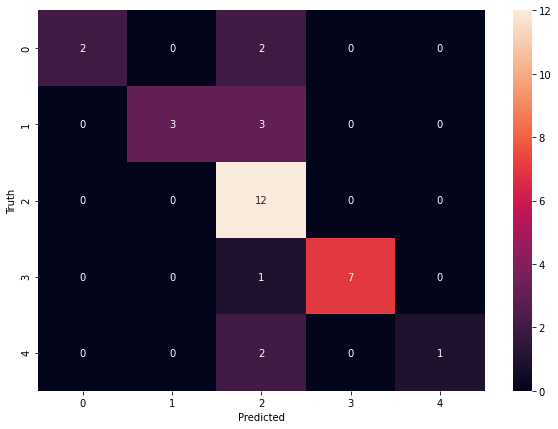

In [48]:
#visualization of the confusion matrix
import seaborn as sn
plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [49]:
class_dict

{'Janakan': 0, 'Shreya': 1, 'Neema': 2, 'lionel_messi': 3, 'Aravinda': 4}

### Save the trained model

In [50]:
!pip install joblib
import joblib 
# Save the model as a pickle in a file 
joblib.dump(best_clf, 'saved_model.pkl') 

DEPRECATION: pyodbc 4.0.0-unsupported has a non-standard version number. pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pyodbc or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063


['saved_model.pkl']

### Save class dictionary

In [51]:
#saving the dictionary of the class file and their
#corresponsive number for the further use in the class dictionary
import json
with open("class_dictionary.json","w") as f:
    f.write(json.dumps(class_dict))